**Instalar bibliotecas de Python**

In [93]:
%%capture
!pip install roboflow
!pip install ultralytics opencv-python matplotlib --quiet
!pip install huggingface_hub git-lfs --quiet

**Importamos Librerias**

In [94]:
import os
import re
import random
import cv2
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from roboflow import Roboflow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from ultralytics import YOLO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.io
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF

from huggingface_hub import notebook_login


# TorchScript
import glob
import time


**Descargar y acondicionar base de datos**

In [34]:
# Descargar dataset desde Roboflow
rf = Roboflow(api_key="yWU6PgeRmz9awH9egdBM")  # tu API key
project = rf.workspace().project("detect-project-lqv4y")  # tu proyecto
version = project.version(1)
dataset = version.download("yolov8")

# Conectar eso con el resto del código
DATASET_ROOT = Path(dataset.location)      # carpeta raíz del dataset
DATA_YAML_PATH = DATASET_ROOT / "data.yaml"

print("DATASET_ROOT:", DATASET_ROOT)
print("DATA_YAML_PATH:", DATA_YAML_PATH, "| Existe:", DATA_YAML_PATH.is_file())


loading Roboflow workspace...
loading Roboflow project...
DATASET_ROOT: /content/Detect-Project-1
DATA_YAML_PATH: /content/Detect-Project-1/data.yaml | Existe: True


In [29]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# Celda 1: comprobación de GPU y version de pytorch


print("Versión de PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))
else:
    print("Entrenarás en CPU (más lento).")


Versión de PyTorch: 2.9.0+cu126
CUDA disponible: True
Dispositivo: Tesla T4


In [61]:
# Celda 2: configuración general del experimento

# DATASET_ROOT y DATA_YAML_PATH ya vienen de la celda de Roboflow

# Modelo base YOLO
BASE_MODEL = "yolov8s.pt"

# Parámetros de entrenamiento
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 30
PATIENCE = 15         # early stopping
LR0 = 0.001           # learning rate inicial

# Dónde se guardará el entrenamiento de Ultralytics
PROJECT_NAME = "signs_detection"
RUN_NAME = "yolov8n_signs"

print("Usando data.yaml en:", DATA_YAML_PATH)


Usando data.yaml en: /content/Detect-Project-1/data.yaml


Contenido de data.yaml:
{'names': ['10',
           '100',
           '110',
           '120',
           '20',
           '30',
           '40',
           '50',
           '60',
           '70',
           '80',
           '90',
           'rojo',
           'stop',
           'verde'],
 'nc': 15,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'detect-project-lqv4y',
              'url': 'https://universe.roboflow.com/universidad-nacional-o6onq/detect-project-lqv4y/dataset/1',
              'version': 1,
              'workspace': 'universidad-nacional-o6onq'},
 'test': '../test/images',
 'train': '../train/images',
 'val': '../valid/images'}

Carpeta de train (images): /content/Detect-Project-1/train/images
Número de imágenes de train detectadas: 6758


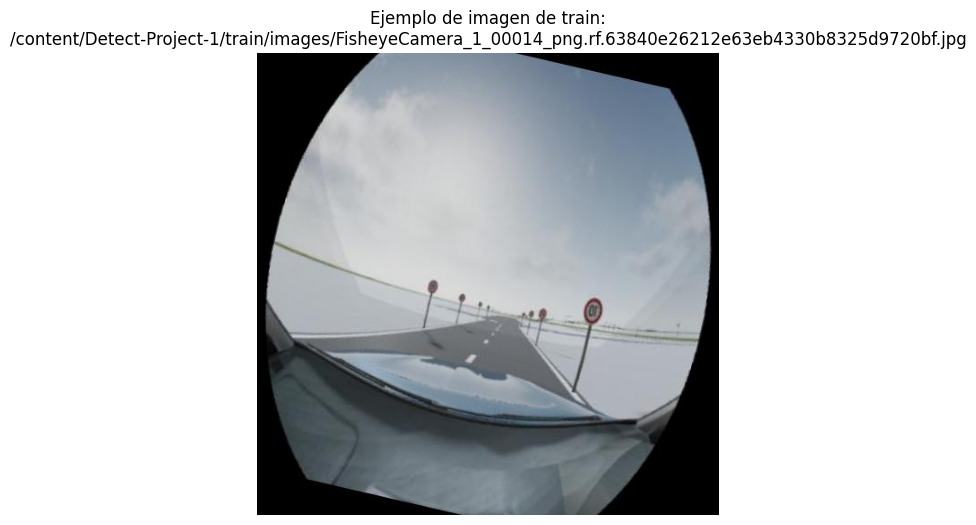

In [62]:
# Celda 3: inspeccionar el data.yaml y mostrar un par de imágenes

import yaml
from pprint import pprint
import glob
import cv2
import matplotlib.pyplot as plt

assert DATA_YAML_PATH.is_file(), f"No se encontró el archivo data.yaml en {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

print("Contenido de data.yaml:")
pprint(data_cfg)

# Roboflow (YOLOv8) suele crear train/valid/test con subcarpetas images/labels
train_images_dir = DATASET_ROOT / "train" / "images"

sample_images = glob.glob(str(train_images_dir / "*.jpg"))
sample_images += glob.glob(str(train_images_dir / "*.png"))

print(f"\nCarpeta de train (images): {train_images_dir}")
print(f"Número de imágenes de train detectadas: {len(sample_images)}")

if len(sample_images) > 0:
    img_path = sample_images[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Ejemplo de imagen de train:\n{img_path}")
    plt.show()
else:
    print("No se encontraron imágenes en train/images. Revisa la estructura del dataset.")


**Entrenar modelo YOLO**

In [63]:
# Celda 4: entrenamiento del modelo YOLO para deteccion de senales

# Cargar modelo base (pre-entrenado en COCO)
model = YOLO(BASE_MODEL)

print("Modelo base cargado:", BASE_MODEL)

# Entrenamiento
results = model.train(
    data=str(DATA_YAML_PATH),
    imgsz=IMG_SIZE,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    patience=PATIENCE,
    lr0=LR0,
    optimizer="SGD",
    project=PROJECT_NAME,
    name=RUN_NAME,
    pretrained=True,
    device=0 if torch.cuda.is_available() else "cpu",
    verbose=True
)

print("\nEntrenamiento terminado.")


Modelo base cargado: yolov8s.pt
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Detect-Project-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_signs4, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, pati

Directorio del experimento: runs/detect/yolov8n_signs
Archivo de resultados: /content/signs_detection/yolov8n_signs4/results.csv | Existe: True


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,139.572,1.18204,4.34896,1.47910,0.15085,0.31614,0.16742,0.11930,1.02284,2.38116,1.41707,0.067078,0.000333,0.000333
1,2,273.749,0.95178,2.25680,1.26700,0.25250,0.55841,0.31900,0.24517,0.81701,1.75583,1.14872,0.034056,0.000644,0.000644
2,3,408.698,0.86861,1.77964,1.17540,0.54995,0.51000,0.52795,0.40959,0.85595,1.41606,1.16944,0.001012,0.000933,0.000933
3,4,542.891,0.79431,1.42375,1.11695,0.78234,0.62099,0.71657,0.58554,0.73392,0.93344,1.06404,0.000901,0.000901,0.000901
4,5,676.094,0.74420,1.18092,1.08556,0.75693,0.68520,0.78433,0.64213,0.70085,0.83308,1.04472,0.000868,0.000868,0.000868


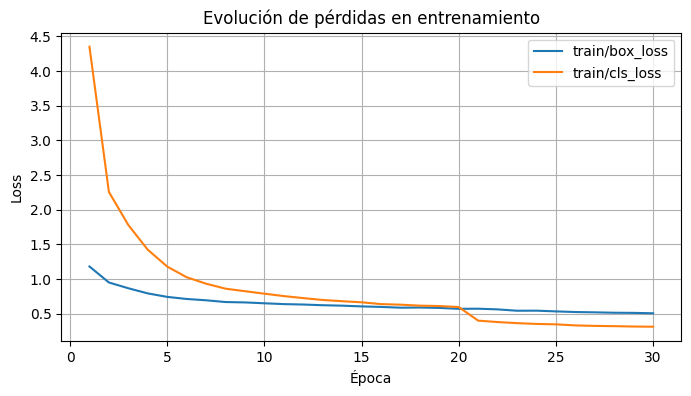

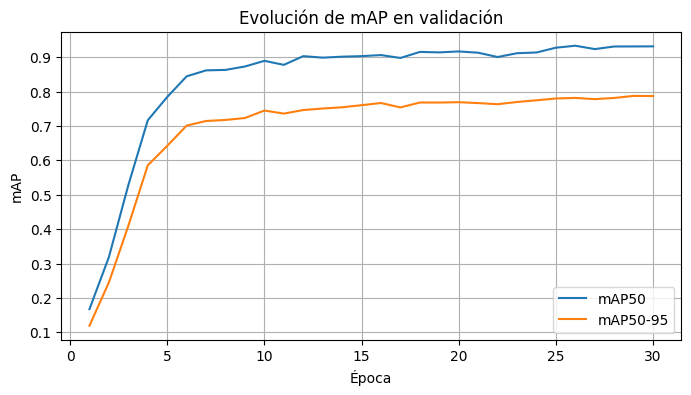

In [71]:
# Celda 5: cargar resultados (mAP, pérdidas, etc.)


#/content/signs_detection/yolov8n_signs3/results.csv
runs_dir = Path("runs/detect") / RUN_NAME
print("Directorio del experimento:", runs_dir)

results_file = runs_dir / "/content/signs_detection/yolov8n_signs4/results.csv"
print("Archivo de resultados:", results_file, "| Existe:", results_file.is_file())

# Leer el CSV y graficar


if results_file.is_file():
    df = pd.read_csv(results_file)
    display(df.head())

    plt.figure(figsize=(8,4))
    plt.plot(df["epoch"], df["train/box_loss"], label="train/box_loss")
    plt.plot(df["epoch"], df["train/cls_loss"], label="train/cls_loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Evolución de pérdidas en entrenamiento")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95")
    plt.xlabel("Época")
    plt.ylabel("mAP")
    plt.title("Evolución de mAP en validación")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se encontró results.csv. Revisa que el entrenamiento se haya ejecutado correctamente.")


Directorio del experimento (train): /content/signs_detection/yolov8n_signs4
confusion_matrix.png existe: True
F1_curve.png existe: True


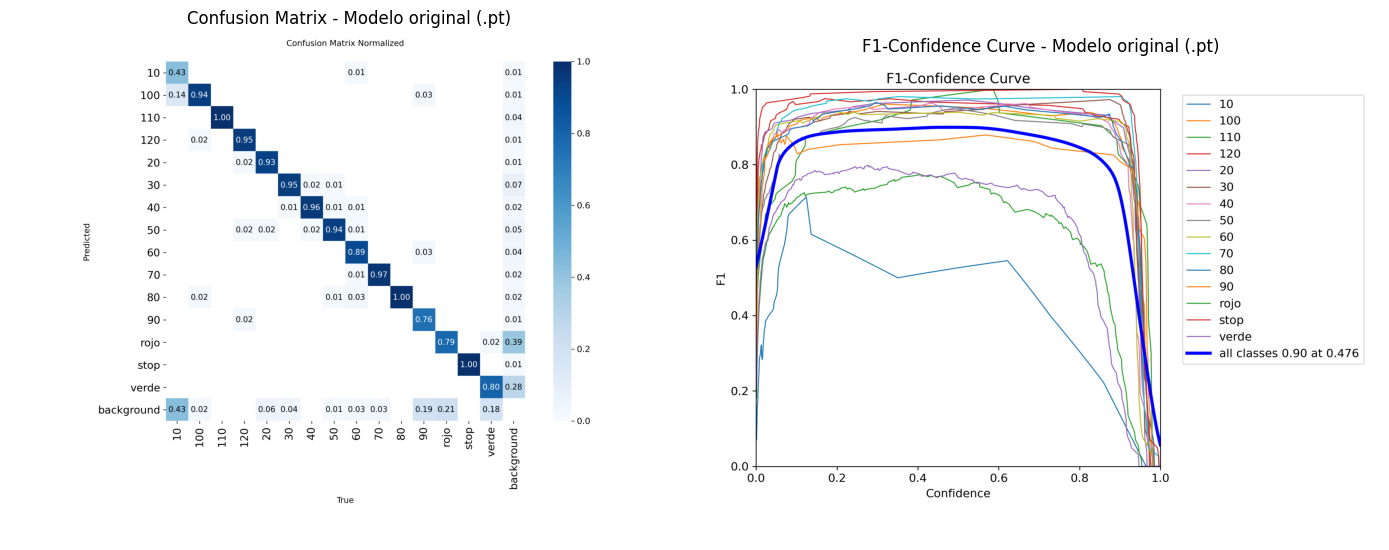

In [90]:
# Celda de la matriz: mostrar matriz de confusión y curva F1-Confidence del modelo original (.pt)

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# run_dir es la carpeta donde YOLO guardó el entrenamiento
# (…/signs_detection/yolov8n_signs4/)
run_dir = Path(MODEL_PT_PATH).parent.parent
print("Directorio del experimento (train):", run_dir)

cm_path = run_dir / "/content/signs_detection/yolov8n_signs4/confusion_matrix_normalized.png"
f1_path = run_dir / "/content/signs_detection/yolov8n_signs4/BoxF1_curve.png"

print("confusion_matrix.png existe:", cm_path.is_file())
print("F1_curve.png existe:", f1_path.is_file())

if cm_path.is_file() and f1_path.is_file():
    cm_img = Image.open(cm_path)
    f1_img = Image.open(f1_path)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(cm_img)
    axes[0].axis("off")
    axes[0].set_title("Confusion Matrix - Modelo original (.pt)")

    axes[1].imshow(f1_img)
    axes[1].axis("off")
    axes[1].set_title("F1-Confidence Curve - Modelo original (.pt)")

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron los archivos de matriz de confusión o F1_curve en el directorio del experimento.")


In [72]:
# Celda 6: obtener la ruta del mejor modelo (best.pt) en Colab
from pathlib import Path


run_dir = Path("/content/signs_detection/yolov8n_signs4")
print("Directorio del experimento:", run_dir)

best_weight_path = run_dir / "weights" / "best.pt"
print("Ruta esperada de best.pt:", best_weight_path)
print("¿Existe best.pt?:", best_weight_path.is_file())

if not best_weight_path.is_file():
    raise FileNotFoundError(
        f"No se encontró best.pt en {best_weight_path}. "
        "Revisa que el entrenamiento haya terminado bien y que PROJECT_NAME y RUN_NAME "
        "sean los mismos que usaste en model.train()."
    )


Directorio del experimento: /content/signs_detection/yolov8n_signs4
Ruta esperada de best.pt: /content/signs_detection/yolov8n_signs4/weights/best.pt
¿Existe best.pt?: True


Modelo entrenado cargado desde: /content/signs_detection/yolov8n_signs4/weights/best.pt
Carpeta de validación: /content/Detect-Project-1/valid/images
Número de imágenes de validación: 802

image 1/1 /content/Detect-Project-1/valid/images/000159_jpg.rf.efc67a65748b260b635168937f7d9959.jpg: 640x640 1 50, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


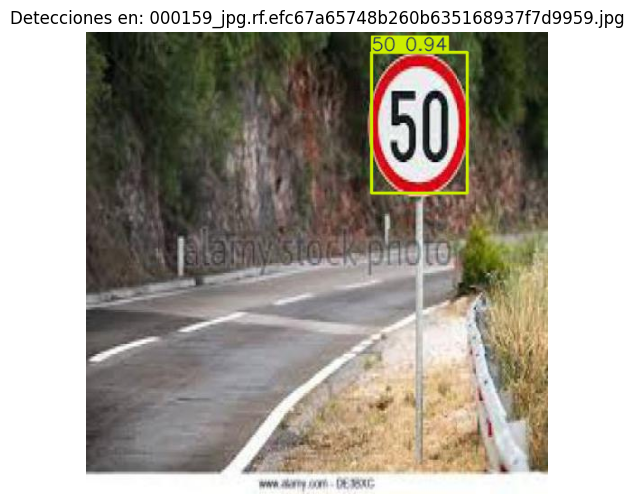


image 1/1 /content/Detect-Project-1/valid/images/00014_00009_00005_png.rf.78ec10a2bd9f8a59a0fb1aec08a1c331.jpg: 640x640 1 stop, 16.4ms
Speed: 3.7ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


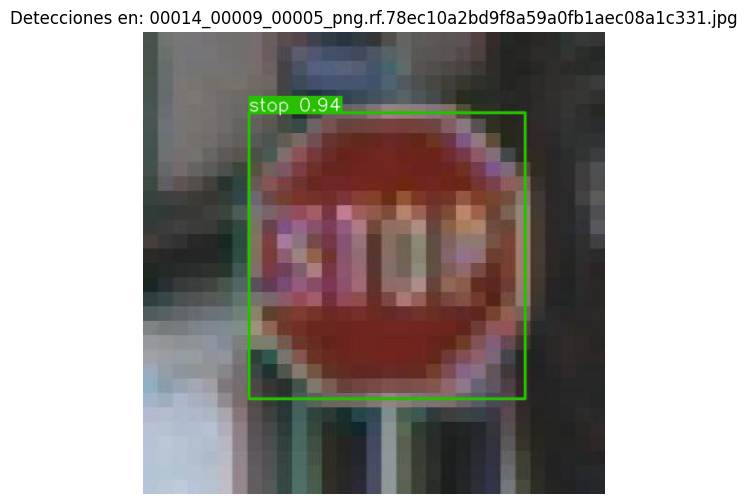


image 1/1 /content/Detect-Project-1/valid/images/00003_00044_00004_png.rf.f7954a546658a2106e45dc29402b96f6.jpg: 640x640 1 60, 16.4ms
Speed: 3.7ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


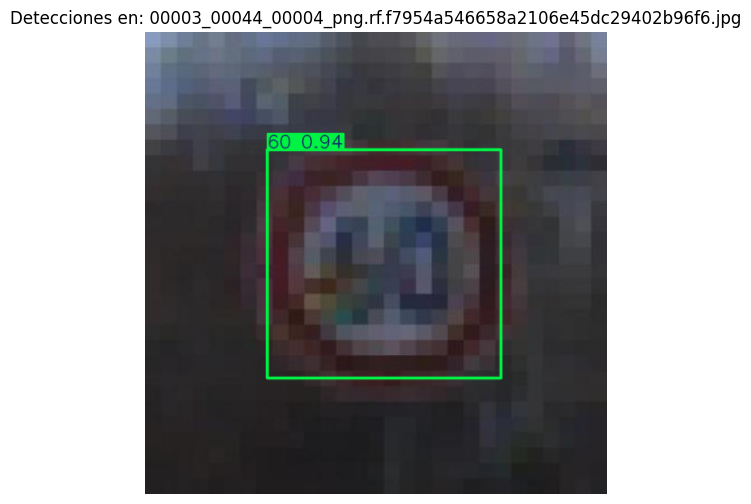


image 1/1 /content/Detect-Project-1/valid/images/000098_jpg.rf.6fc92f1de12bd2415ac9010d6ab460c4.jpg: 640x640 1 30, 16.4ms
Speed: 3.7ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


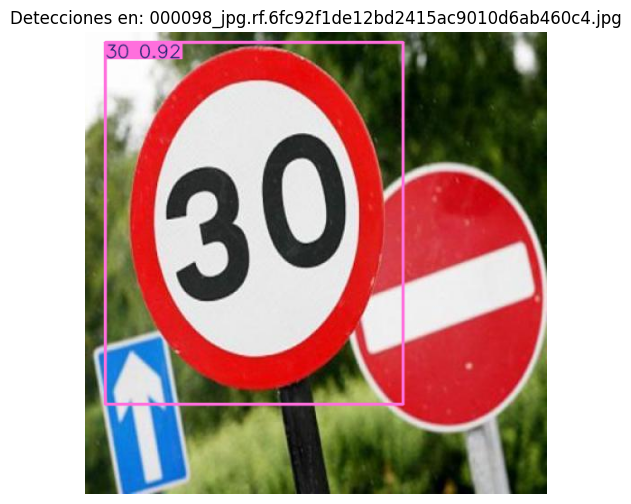

In [73]:
# Celda 7: inferencia rápida en imágenes de validación (dataset Roboflow)

# Cargar el modelo entrenado desde best.pt
model_trained = YOLO(str(best_weight_path))
print("Modelo entrenado cargado desde:", best_weight_path)

# En el export de Roboflow para YOLOv8 la validación suele estar en 'valid/images'
val_images_dir = DATASET_ROOT / "valid" / "images"
val_images = glob.glob(str(val_images_dir / "*.jpg"))
val_images += glob.glob(str(val_images_dir / "*.png"))

print("Carpeta de validación:", val_images_dir)
print("Número de imágenes de validación:", len(val_images))

if len(val_images) > 0:
    for img_path in val_images[:4]:   # muestra las primeras 4
        results = model_trained(img_path, imgsz=IMG_SIZE, conf=0.4)
        r = results[0]

        im_bgr = r.plot()
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(im_rgb)
        plt.axis("off")
        plt.title(f"Detecciones en: {Path(img_path).name}")
        plt.show()
else:
    print("No se encontraron imágenes en valid/images.")


# **Exportar modelo a TorchScript**

In [74]:
# Celda 8: seleccionar ruta del modelo .pt y una imagen de validación

# Intentamos usar best_weight_path si ya existe
try:
    MODEL_PT_PATH = best_weight_path
    print("Usando best_weight_path ya definido:", MODEL_PT_PATH)
except NameError:

    MODEL_PT_PATH = Path("/content/signs_detection/yolov8n_signs4/weights/best.pt")
    print("Usando ruta fija de best.pt:", MODEL_PT_PATH)

print("¿Existe el modelo?:", MODEL_PT_PATH.is_file())
if not MODEL_PT_PATH.is_file():
    raise FileNotFoundError(f"No se encontró el modelo en {MODEL_PT_PATH}")

# Buscar carpeta de validación (Roboflow a veces usa valid/, a veces val/)
candidatos_val = [
    DATASET_ROOT / "valid" / "images",
    DATASET_ROOT / "val" / "images",
    DATASET_ROOT / "validation" / "images",
]

val_images_dir = None
for d in candidatos_val:
    if d.is_dir():
        val_images_dir = d
        break

print("Directorio de validación detectado:", val_images_dir)

if val_images_dir is None:
    raise FileNotFoundError(
        "No se encontró carpeta de validación en valid/images, val/images ni validation/images."
    )

val_images = glob.glob(str(val_images_dir / "*.jpg")) + glob.glob(str(val_images_dir / "*.png"))
print("Número de imágenes de validación:", len(val_images))

if len(val_images) == 0:
    raise FileNotFoundError("No se encontraron imágenes en la carpeta de validación.")

SAMPLE_IMAGE = Path(val_images[0])
print("Usaremos esta imagen de ejemplo:", SAMPLE_IMAGE)


Usando best_weight_path ya definido: /content/signs_detection/yolov8n_signs4/weights/best.pt
¿Existe el modelo?: True
Directorio de validación detectado: /content/Detect-Project-1/valid/images
Número de imágenes de validación: 802
Usaremos esta imagen de ejemplo: /content/Detect-Project-1/valid/images/000159_jpg.rf.efc67a65748b260b635168937f7d9959.jpg


Modelo original cargado desde: /content/signs_detection/yolov8n_signs4/weights/best.pt

image 1/1 /content/Detect-Project-1/valid/images/000159_jpg.rf.efc67a65748b260b635168937f7d9959.jpg: 640x640 1 50, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Tiempo de inferencia PyTorch (.pt): 155.7 ms


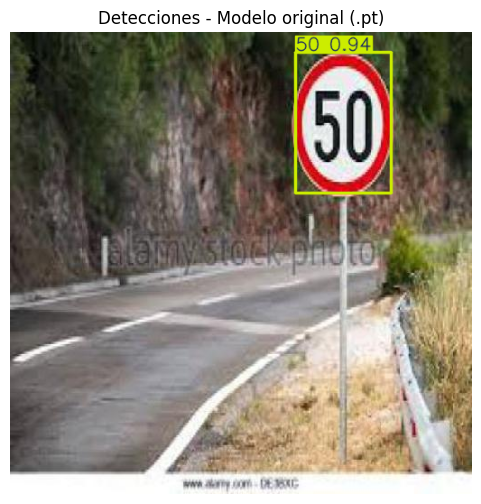

Clases detectadas en esta imagen:
- 50 (conf=0.94)
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from '/content/signs_detection/yolov8n_signs4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (21.5 MB)

TorchScript: starting export with torch 2.9.0+cu126...
TorchScript: export success ✅ 3.4s, saved as '/content/signs_detection/yolov8n_signs4/weights/best.torchscript' (42.9 MB)

Export complete (4.4s)
Results saved to /content/signs_detection/yolov8n_signs4/weights
Predict:         yolo predict task=detect model=/content/signs_detection/yolov8n_signs4/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/signs_detection/yolov8n_signs4/weights/best.torchscript imgsz=640 data=/content/Detect-Project-1/data.yaml  
Visualize:       https://netron.app

Archivo exportado por Ultralytics: /content/signs_detection/yolov8n_signs4/weights/best.torchscript
Ruta To

In [80]:
# Celda 9: inferencia con el modelo original (.pt) y exportación a TorchScript

# Si ya definiste IMG_SIZE antes, usamos ese; si no, por defecto 640
try:
    IMG_SIZE
except NameError:
    IMG_SIZE = 640

# Cargar modelo original
model = YOLO(str(MODEL_PT_PATH))
print("Modelo original cargado desde:", MODEL_PT_PATH)

# Inferencia con el modelo original
start = time.time()
results = model(str(SAMPLE_IMAGE), imgsz=IMG_SIZE)
elapsed_pytorch = (time.time() - start) * 1000
print(f"Tiempo de inferencia PyTorch (.pt): {elapsed_pytorch:.1f} ms")

r = results[0]
im_bgr = r.plot()
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(im_rgb)
plt.axis("off")
plt.title("Detecciones - Modelo original (.pt)")
plt.show()

print("Clases detectadas en esta imagen:")
for box in r.boxes:
    cls_id = int(box.cls[0])
    cls_name = r.names[cls_id]
    conf = float(box.conf[0])
    print(f"- {cls_name} (conf={conf:.2f})")

# Exportar a TorchScript SIN optimizaciones xnnpack (para que no reviente)
exported_file = model.export(
    format="torchscript",
    imgsz=IMG_SIZE,
    optimize=False   # 👈 CAMBIO IMPORTANTE
)

print("\nArchivo exportado por Ultralytics:", exported_file)

from pathlib import Path
TS_MODEL_PATH = Path(exported_file)
print("Ruta TorchScript:", TS_MODEL_PATH, "| Existe:", TS_MODEL_PATH.is_file())

if not TS_MODEL_PATH.is_file():
    raise FileNotFoundError("No se generó el archivo TorchScript correctamente.")



**Desempeño del modelo en TorchScript**

Modelo TorchScript cargado desde: /content/signs_detection/yolov8n_signs4/weights/best.torchscript
Loading /content/signs_detection/yolov8n_signs4/weights/best.torchscript for TorchScript inference...

image 1/1 /content/Detect-Project-1/valid/images/000159_jpg.rf.efc67a65748b260b635168937f7d9959.jpg: 640x640 1 50, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Tiempo de inferencia TorchScript: 665.5 ms


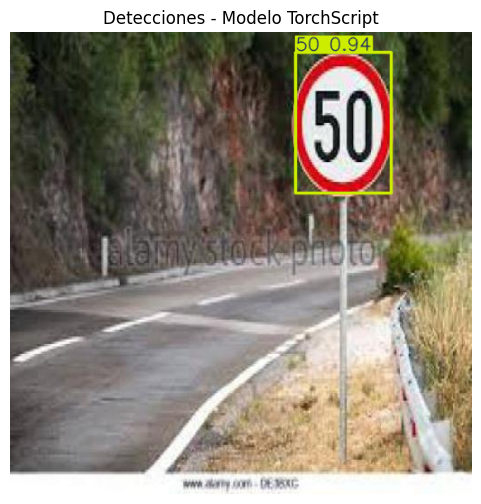


=== Comparación de tiempos en UNA imagen ===
PyTorch (.pt):     155.7 ms
TorchScript (.ts): 665.5 ms


In [82]:
# Celda 10: cargar el modelo TorchScript y comparar con el original

# Cargar modelo TorchScript, indicando explícitamente que es detección
ts_model = YOLO(str(TS_MODEL_PATH), task="detect")
print("Modelo TorchScript cargado desde:", TS_MODEL_PATH)

# Inferencia con TorchScript en la misma imagen
start = time.time()
ts_results = ts_model(str(SAMPLE_IMAGE), imgsz=IMG_SIZE)
elapsed_ts = (time.time() - start) * 1000
print(f"Tiempo de inferencia TorchScript: {elapsed_ts:.1f} ms")

ts_r = ts_results[0]
ts_im_bgr = ts_r.plot()
ts_im_rgb = cv2.cvtColor(ts_im_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(ts_im_rgb)
plt.axis("off")
plt.title("Detecciones - Modelo TorchScript")
plt.show()

print("\n=== Comparación de tiempos en UNA imagen ===")
print(f"PyTorch (.pt):     {elapsed_pytorch:.1f} ms")
print(f"TorchScript (.ts): {elapsed_ts:.1f} ms")


In [83]:
# Celda 11: benchmark rápido de varias corridas

def benchmark(model, image_path, n=20, label="modelo"):
    t0 = time.time()
    for _ in range(n):
        _ = model(str(image_path), imgsz=IMG_SIZE, verbose=False)
    t1 = time.time()
    avg_ms = (t1 - t0) * 1000 / n
    print(f"{label}: {avg_ms:.2f} ms de media en {n} corridas")
    return avg_ms

print("Benchmark sobre la misma imagen:")
avg_pt = benchmark(model, SAMPLE_IMAGE, n=20, label="PyTorch (.pt)")
avg_ts = benchmark(ts_model, SAMPLE_IMAGE, n=20, label="TorchScript (.ts)")


Benchmark sobre la misma imagen:
PyTorch (.pt): 18.59 ms de media en 20 corridas
TorchScript (.ts): 13.45 ms de media en 20 corridas


Modelo TorchScript cargado desde: /content/signs_detection/yolov8n_signs4/weights/best.torchscript
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/signs_detection/yolov8n_signs4/weights/best.torchscript for TorchScript inference...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 704.1±235.7 MB/s, size: 19.9 KB)
val: Scanning /content/Detect-Project-1/valid/labels.cache... 802 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 802/802 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 5.2it/s 9.8s
                   all        802        948      0.935      0.863      0.927      0.781
                    10          7          7      0.671      0.429      0.495      0.204
                   100         52         52      0.969      0.923      0.986      0.899
                   110         17         17      0.926      0.941       0.98      0.875
          

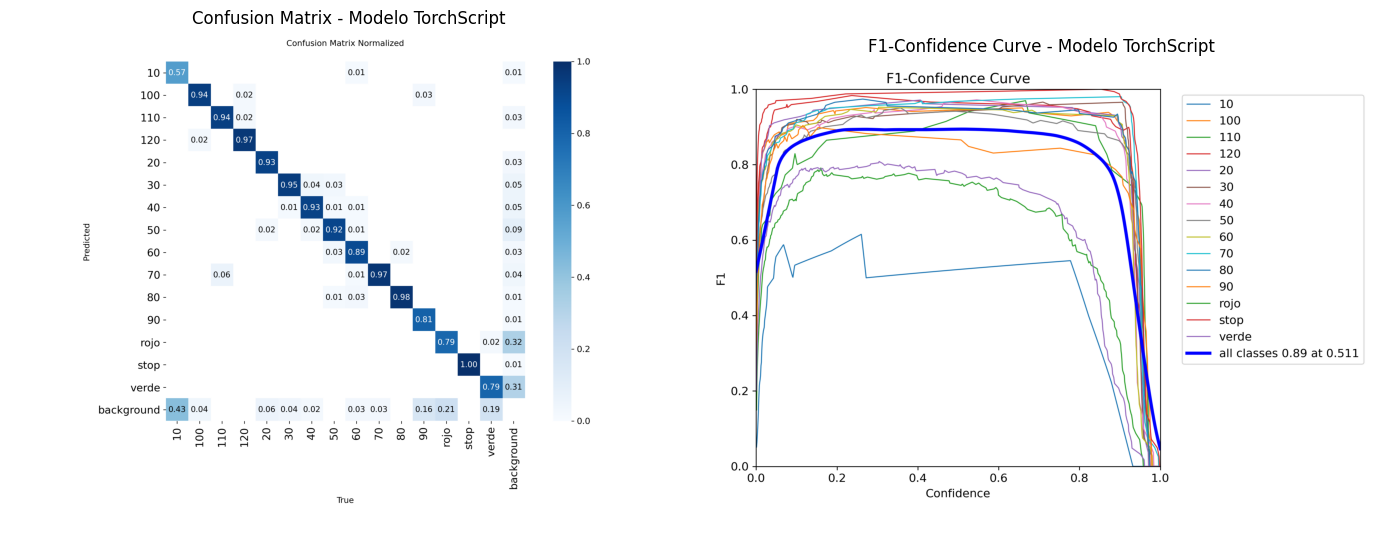

In [92]:
# Celda 12: evaluar el modelo TorchScript y generar su matriz de confusión y curva F1-Confidence

from PIL import Image


# Nos aseguramos de tener el tamaño de imagen
try:
    IMG_SIZE
except NameError:
    IMG_SIZE = 640

# Cargar modelo TorchScript (detección)
ts_model = YOLO(str(TS_MODEL_PATH), task="detect")
print("Modelo TorchScript cargado desde:", TS_MODEL_PATH)

# Evaluar en el split de validación usando el mismo data.yaml
metrics_ts = ts_model.val(
    data=str(DATA_YAML_PATH),
    split="val",       # o "valid", según tu data.yaml, pero normalmente "val"
    imgsz=IMG_SIZE,
    plots=True         # 👈 genera confusion_matrix.png y F1_curve.png
)

print("mAP50 (TS):", metrics_ts.box.map50)
print("mAP50-95 (TS):", metrics_ts.box.map)

ts_save_dir = Path(metrics_ts.save_dir)
print("Resultados de validación TorchScript guardados en:", ts_save_dir)

cm_ts_path = ts_save_dir / "/content/runs/detect/val2/confusion_matrix_normalized.png"
f1_ts_path = ts_save_dir / "/content/runs/detect/val2/BoxF1_curve.png"

print("confusion_matrix (TS) existe:", cm_ts_path.is_file())
print("F1_curve (TS) existe:", f1_ts_path.is_file())

if cm_ts_path.is_file() and f1_ts_path.is_file():
    cm_ts_img = Image.open(cm_ts_path)
    f1_ts_img = Image.open(f1_ts_path)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(cm_ts_img)
    axes[0].axis("off")
    axes[0].set_title("Confusion Matrix - Modelo TorchScript")

    axes[1].imshow(f1_ts_img)
    axes[1].axis("off")
    axes[1].set_title("F1-Confidence Curve - Modelo TorchScript")

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron las imágenes de matriz de confusión o F1_curve para el modelo TorchScript.")


## **Hugging Face**

In [95]:
notebook_login()

**Definir usuario, nombre del Space y clonar repo**

In [97]:
# HF-2: definir usuario y Space, y clonar el repositorio del Space

from huggingface_hub import HfApi

HF_USER = "camilosss"
SPACE_NAME = "TrafficSignDetectionYOLO"  # 🔴 CAMBIA ESTO al nombre del Space que creaste

REPO_URL = f"https://huggingface.co/spaces/{HF_USER}/{SPACE_NAME}"
print("Usando repo:", REPO_URL)

!git clone {REPO_URL}
%cd {SPACE_NAME}

# Configurar Git LFS para archivos de modelos
!git lfs install
!git lfs track "*.pt"
!git lfs track "*.torchscript"
!git add .gitattributes


Usando repo: https://huggingface.co/spaces/camilosss/TrafficSignDetectionYOLO
Cloning into 'TrafficSignDetectionYOLO'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.28 KiB | 1.28 MiB/s, done.
/content/TrafficSignDetectionYOLO
Updated git hooks.
Git LFS initialized.
"*.pt" already supported
Tracking "*.torchscript"


In [98]:
# HF-3: copiar el modelo TorchScript dentro del directorio del Space

from pathlib import Path
import shutil

# Fichero que se usará dentro del Space
MODEL_FILENAME = "traffic_signs_yolo.torchscript"

print("TS_MODEL_PATH:", TS_MODEL_PATH)

dest_path = Path(MODEL_FILENAME)
shutil.copy2(str(TS_MODEL_PATH), dest_path)

print("Modelo copiado a:", dest_path.resolve())


TS_MODEL_PATH: /content/signs_detection/yolov8n_signs4/weights/best.torchscript
Modelo copiado a: /content/TrafficSignDetectionYOLO/traffic_signs_yolo.torchscript


In [99]:
# HF-4: crear la API FastAPI para detección de señales con YOLO

%%writefile app.py
from fastapi import FastAPI
from pydantic import BaseModel
import base64
import io
from typing import List

import numpy as np
from PIL import Image
from ultralytics import YOLO

MODEL_PATH = "traffic_signs_yolo.torchscript"

app = FastAPI(title="Traffic Sign Detection API")

# Cargar el modelo una sola vez
model = YOLO(MODEL_PATH, task="detect")


class ImagePayload(BaseModel):
    image_base64: str
    conf: float = 0.4  # umbral de confianza opcional


def decode_image(image_base64: str) -> np.ndarray:
    """Decodifica una imagen en base64 a un array NumPy RGB."""
    img_bytes = base64.b64decode(image_base64)
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    return np.array(img)


@app.get("/")
def root():
    return {
        "status": "ok",
        "message": "Traffic sign detection API. Use POST /predict con una imagen en base64.",
    }


@app.get("/health")
def health():
    return {"status": "healthy", "model_loaded": True}


@app.post("/predict")
def predict(payload: ImagePayload):
    try:
        img_np = decode_image(payload.image_base64)

        # Inferencia con YOLO
        results = model(img_np, conf=payload.conf, verbose=False)
        r = results[0]

        detections = []
        names = r.names

        for box in r.boxes:
            cls_id = int(box.cls[0])
            class_name = names[cls_id]
            confidence = float(box.conf[0])
            x1, y1, x2, y2 = [float(v) for v in box.xyxy[0].tolist()]

            detections.append(
                {
                    "class_id": cls_id,
                    "class_name": class_name,
                    "confidence": confidence,
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2,
                }
            )

        return {
            "num_detections": len(detections),
            "detections": detections,
            "image_size": img_np.shape[:2],  # (alto, ancho)
        }

    except Exception as e:
        return {"status": "error", "message": str(e)}


Writing app.py


**Crear requirements.txt, runtime.txt, README.md y Dockerfile**

In [100]:
# HF-5: requirements.txt

%%writefile requirements.txt
fastapi
uvicorn[standard]
pydantic
numpy
pillow
ultralytics
torch
torchvision


Writing requirements.txt


In [101]:
# HF-6: runtime.txt (versión de Python para el Space)

%%writefile runtime.txt
python-3.10


Writing runtime.txt


In [102]:
# HF-7: README.md para el Space

%%writefile README.md
---
title: Traffic Sign Detection
emoji: 🚦
colorFrom: blue
colorTo: red
sdk: docker
pinned: false
---

# Traffic Sign Detection API

Este Space expone un modelo YOLO entrenado para detectar señales de tránsito.
La API está construida con FastAPI y devuelve las detecciones en formato JSON.

## Uso rápido

Envía una petición `POST` a `/predict` con un JSON:

```json
{"image_base64": "<imagen codificada en base64>"}


Overwriting README.md


In [104]:

# HF-8: Dockerfile para ejecutar la API en el Space

%%writefile Dockerfile
FROM python:3.10-slim

ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

RUN useradd -m -u 1000 user
USER user

WORKDIR /app

COPY --chown=user requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY --chown=user . .

EXPOSE 7860

CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]


Writing Dockerfile


In [107]:
# HF-9 : configurar identidad de git + commit + push


!git config user.email "jmino@unal.edu.co"
!git config user.name "camilosss"

# Añadimos todos los archivos nuevos y modificados
!git add .gitattributes README.md Dockerfile app.py requirements.txt runtime.txt traffic_signs_yolo.torchscript

# Hacemos el commit (si no hay cambios, no pasa nada)
!git commit -m "Add traffic sign detection API" || echo "Nada que commitear"

# Subimos al Space
!git push



On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Nada que commitear
Everything up-to-date


In [111]:
%cd /content/TrafficSignDetectionYOLO   # o el nombre de tu Space


[Errno 2] No such file or directory: '/content/TrafficSignDetectionYOLO # o el nombre de tu Space'
/content/TrafficSignDetectionYOLO


In [112]:
%%writefile Dockerfile
FROM python:3.10-slim

ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

# Crear usuario sin privilegios
RUN useradd -m -u 1000 user

# ⚠️ Añadir la carpeta de instalacion de scripts (uvicorn, etc.) al PATH
ENV PATH="/home/user/.local/bin:${PATH}"

USER user
WORKDIR /app

# Instalar dependencias como el usuario 'user'
COPY --chown=user requirements.txt .
RUN pip install --no-cache-dir --user -r requirements.txt

# Copiar el resto de archivos del Space
COPY --chown=user . .

EXPOSE 7860

# Lanzar la API con uvicorn
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]


Overwriting Dockerfile


In [113]:
!git add Dockerfile
!git commit -m "Fix PATH so uvicorn is found" || echo "Nada que commitear"
!git push


[main eb30b47] Fix PATH so uvicorn is found
 1 file changed, 9 insertions(+), 2 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 683 bytes | 683.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/camilosss/TrafficSignDetectionYOLO
   55db5be..eb30b47  main -> main


In [114]:
%%writefile Dockerfile
FROM python:3.10-slim

ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

# 📦 Dependencias del sistema que necesita OpenCV (cv2) y compañía
RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
 && rm -rf /var/lib/apt/lists/*

# Crear usuario sin privilegios
RUN useradd -m -u 1000 user

# Añadir la carpeta donde pip instala los binarios (uvicorn, etc.) al PATH
ENV PATH="/home/user/.local/bin:${PATH}"

USER user
WORKDIR /app

# Instalar las dependencias de Python como el usuario 'user'
COPY --chown=user requirements.txt .
RUN pip install --no-cache-dir --user -r requirements.txt

# Copiar el resto de archivos del Space (app.py, modelo, etc.)
COPY --chown=user . .

EXPOSE 7860

# Lanzar la API con uvicorn
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]


Overwriting Dockerfile


In [115]:
!git add Dockerfile
!git commit -m "Add system libs for OpenCV (libGL, libglib)" || echo "Nada que commitear"
!git push


[main 7f6327d] Add system libs for OpenCV (libGL, libglib)
 1 file changed, 9 insertions(+), 3 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 551 bytes | 551.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/camilosss/TrafficSignDetectionYOLO
   eb30b47..7f6327d  main -> main


## **Inferencia**

In [117]:
import base64
import requests
import json
from pathlib import Path

# URL

SPACE_URL = "https://camilosss-trafficsigndetectionyolo.hf.space"

API_URL = f"{SPACE_URL}/predict"
print("Usando endpoint:", API_URL)

# Ruta a una imagen de prueba (en Colab)
img_path = Path("/content/30km.jpg") #imagen de fuera para probar

# Codificar imagen a base64
with img_path.open("rb") as f:
    img_b64 = base64.b64encode(f.read()).decode("utf-8")

payload = {
    "image_base64": img_b64,
    "conf": 0.4,
}

resp = requests.post(API_URL, json=payload)
print("Status code:", resp.status_code)

data = resp.json()
print(json.dumps(data, indent=2, ensure_ascii=False))


Usando endpoint: https://camilosss-trafficsigndetectionyolo.hf.space/predict
Status code: 200
{
  "num_detections": 1,
  "detections": [
    {
      "class_id": 5,
      "class_name": "30",
      "confidence": 0.939276397228241,
      "x1": 177.24844360351562,
      "y1": 16.329370498657227,
      "x2": 406.21954345703125,
      "y2": 243.43714904785156
    }
  ],
  "image_size": [
    315,
    474
  ]
}
